In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import missingno as msno
import zipfile
import os
import statsmodels.api as sm
from utils import linmodules as lm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Preparing Dataset and Quick Cleaning

#### 1. Downloading and extracting

In [76]:
!kaggle datasets download -d mirichoi0218/insurance

  0%|                                               | 0.00/16.0k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 16.0k/16.0k [00:00<00:00, 2.35MB/s]


In [77]:
data_path = "./data/insurance"
try:
    os.makedirs(data_path, exist_ok=False)
except FileExistsError:
    print("This directory already exists!")

This directory already exists!


In [78]:
try:
    with zipfile.ZipFile("./insurance.zip", "r") as ins:
        ins.extractall("./data/insurance")
except FileNotFoundError:
    print("File is not found!")

In [79]:
!rm -rf *.zip

#### 2. Reading data

In [80]:
raw_df = pd.read_csv("./data/insurance/insurance.csv", header=0, sep=",")

Exploring columns, dtypes, and general poblational trends.

In [81]:
raw_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [82]:
raw_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [83]:
raw_df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [84]:
raw_df.describe(include=['float', 'int'])

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Inspecting missing or null values:

In [85]:
raw_df.isna().sum() # It is apparently clean

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [86]:
raw_df.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

#### Setting style

In [90]:
font1 = {"family" : "serif", "size" : 20}
font2 = {"family" : "serif", "size" : 10}
palette = ["#01204E", "#028391", "#F6DCAC", "#FEAE6F"]
sns.set_palette(palette=palette)
sns.set_style("ticks")

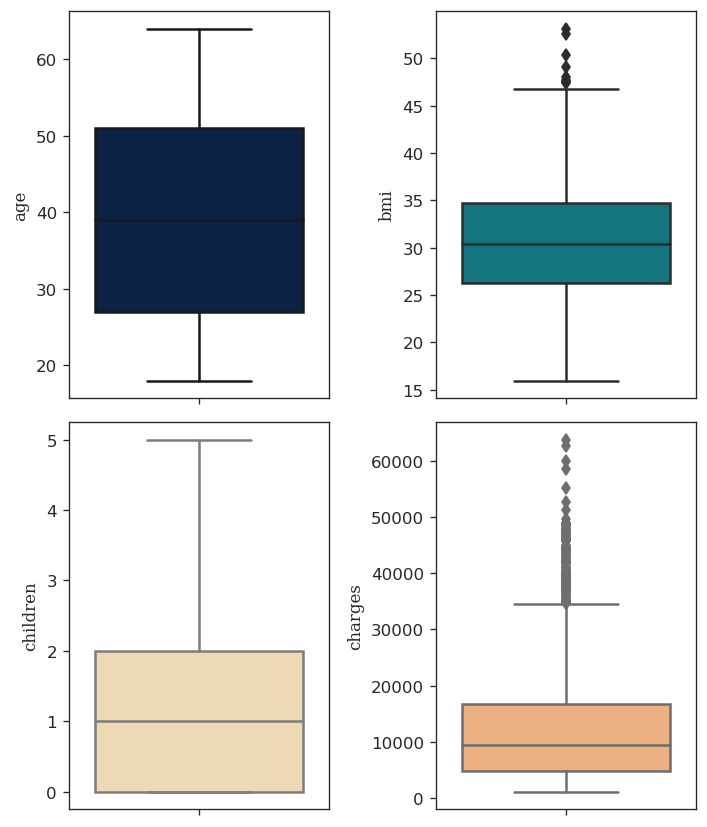

In [91]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6,7), dpi=120, sharex=False, sharey=False)
sns.boxplot(data=raw_df, y="age", hue="sex", showfliers=True, ax=axes.flat[0], color="#01204E")
axes.flat[0].set_ylabel("age", fontdict=font2)
sns.boxplot(data=raw_df, y="bmi", hue="sex", showfliers=True, ax=axes.flat[1], color="#028391")
axes.flat[1].set_ylabel("bmi", fontdict=font2)
sns.boxplot(data=raw_df, y="children", hue="sex", showfliers=True, ax=axes.flat[2], color="#F6DCAC")
axes.flat[2].set_ylabel("children", fontdict=font2)
sns.boxplot(data=raw_df, y="charges", hue="sex", showfliers=True, ax=axes.flat[3], color="#FEAE6F")
axes.flat[3].set_ylabel("charges", fontdict=font2)
plt.tight_layout()

In [145]:
from matplotlib.ticker import FuncFormatter

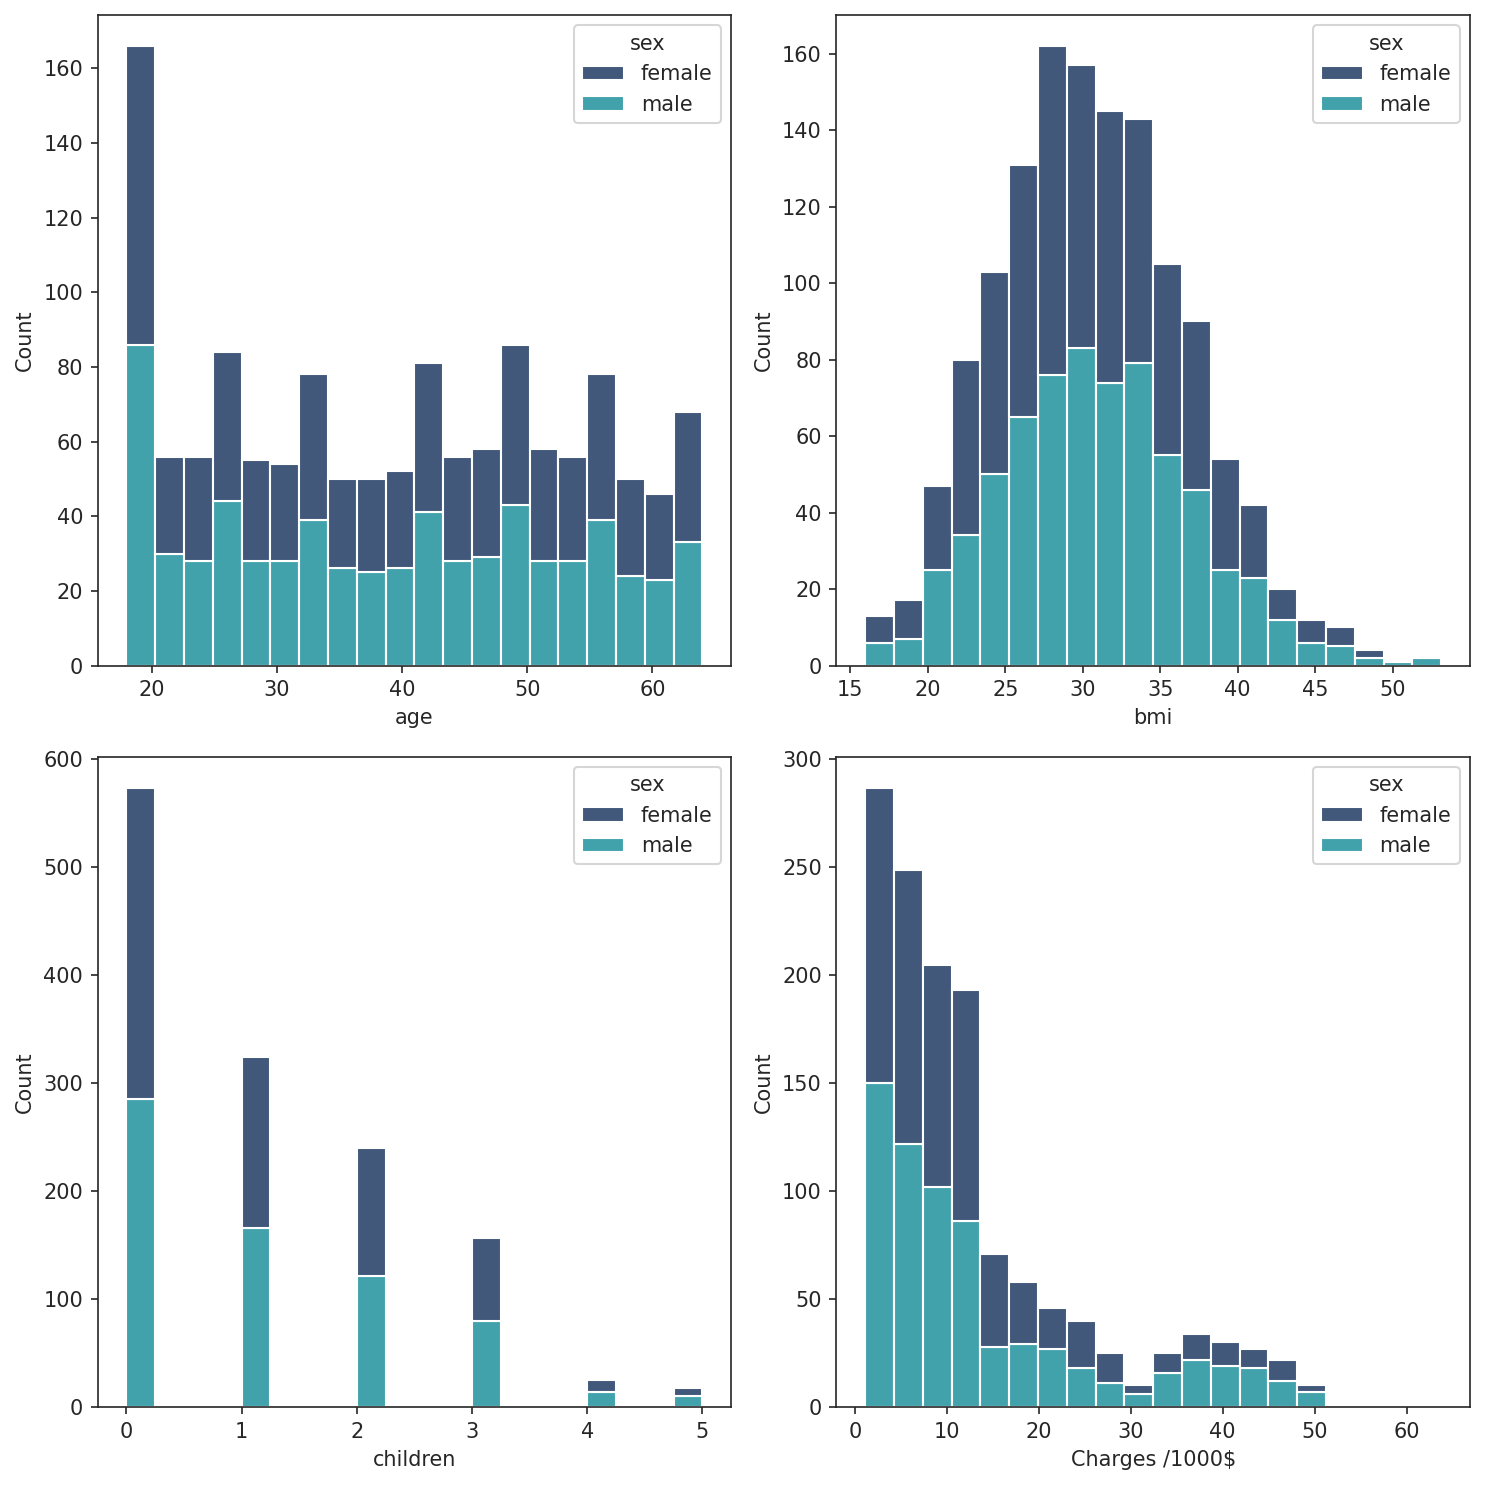

In [146]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(10,10), dpi=150, sharex=False, sharey=False)
sns.histplot(data=raw_df, x="age", hue="sex", bins=20, multiple="stack", ax=axis.flat[0])
sns.histplot(data=raw_df, x="bmi", hue="sex", bins=20, multiple="stack", ax=axis.flat[1])
sns.histplot(data=raw_df, x="children", hue="sex", bins=20, multiple="stack", ax=axis.flat[2])
sns.histplot(data=raw_df, x="charges", hue="sex", bins=20, multiple="stack", ax=axis.flat[3])
def my_formatter(x, pos):
    return f"{x / 1000:.0f}"
formatter = FuncFormatter(my_formatter)
axis.flat[3].xaxis.set_major_formatter(formatter)
axis.flat[3].set_xlabel("Charges /1000$")
plt.tight_layout()
plt.show()

In [93]:
raw_df.charges.quantile(0.995)

50086.98487310009

In [94]:
# Outliers in charges (out of IQR range)
outliers = raw_df[raw_df.charges >= raw_df.charges.quantile(0.995)].sort_values(ascending=False, by="charges")
outliers

,age,sex,bmi,children,smoker,region,charges
543,54,female,47.410,0,yes,southeast,63770.42801
1300,45,male,30.360,0,yes,southeast,62592.87309
1230,52,male,34.485,3,yes,northwest,60021.39897
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
34,28,male,36.400,1,yes,southwest,51194.55914


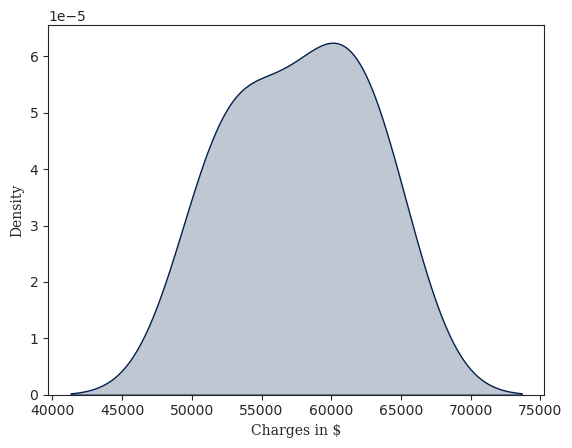

In [95]:
sns.kdeplot(data=outliers, x="charges", fill=True)
plt.xlabel("Charges in $", fontdict=font2)
plt.ylabel("Density", fontdict=font2)
plt.show()

There are some appreciable outliers in `charges` and `bmi` but not as far away as considering as a null value, they can be considered as normal outliers.

In [96]:
corr = raw_df.corr(numeric_only=True) # Poor correlations
corr

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


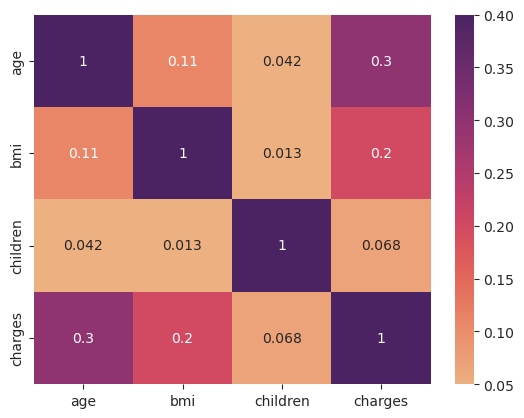

In [97]:
sns.heatmap(data=corr, cbar=True, annot=True, vmin=0.05, vmax=0.4, cmap="flare")
plt.show()

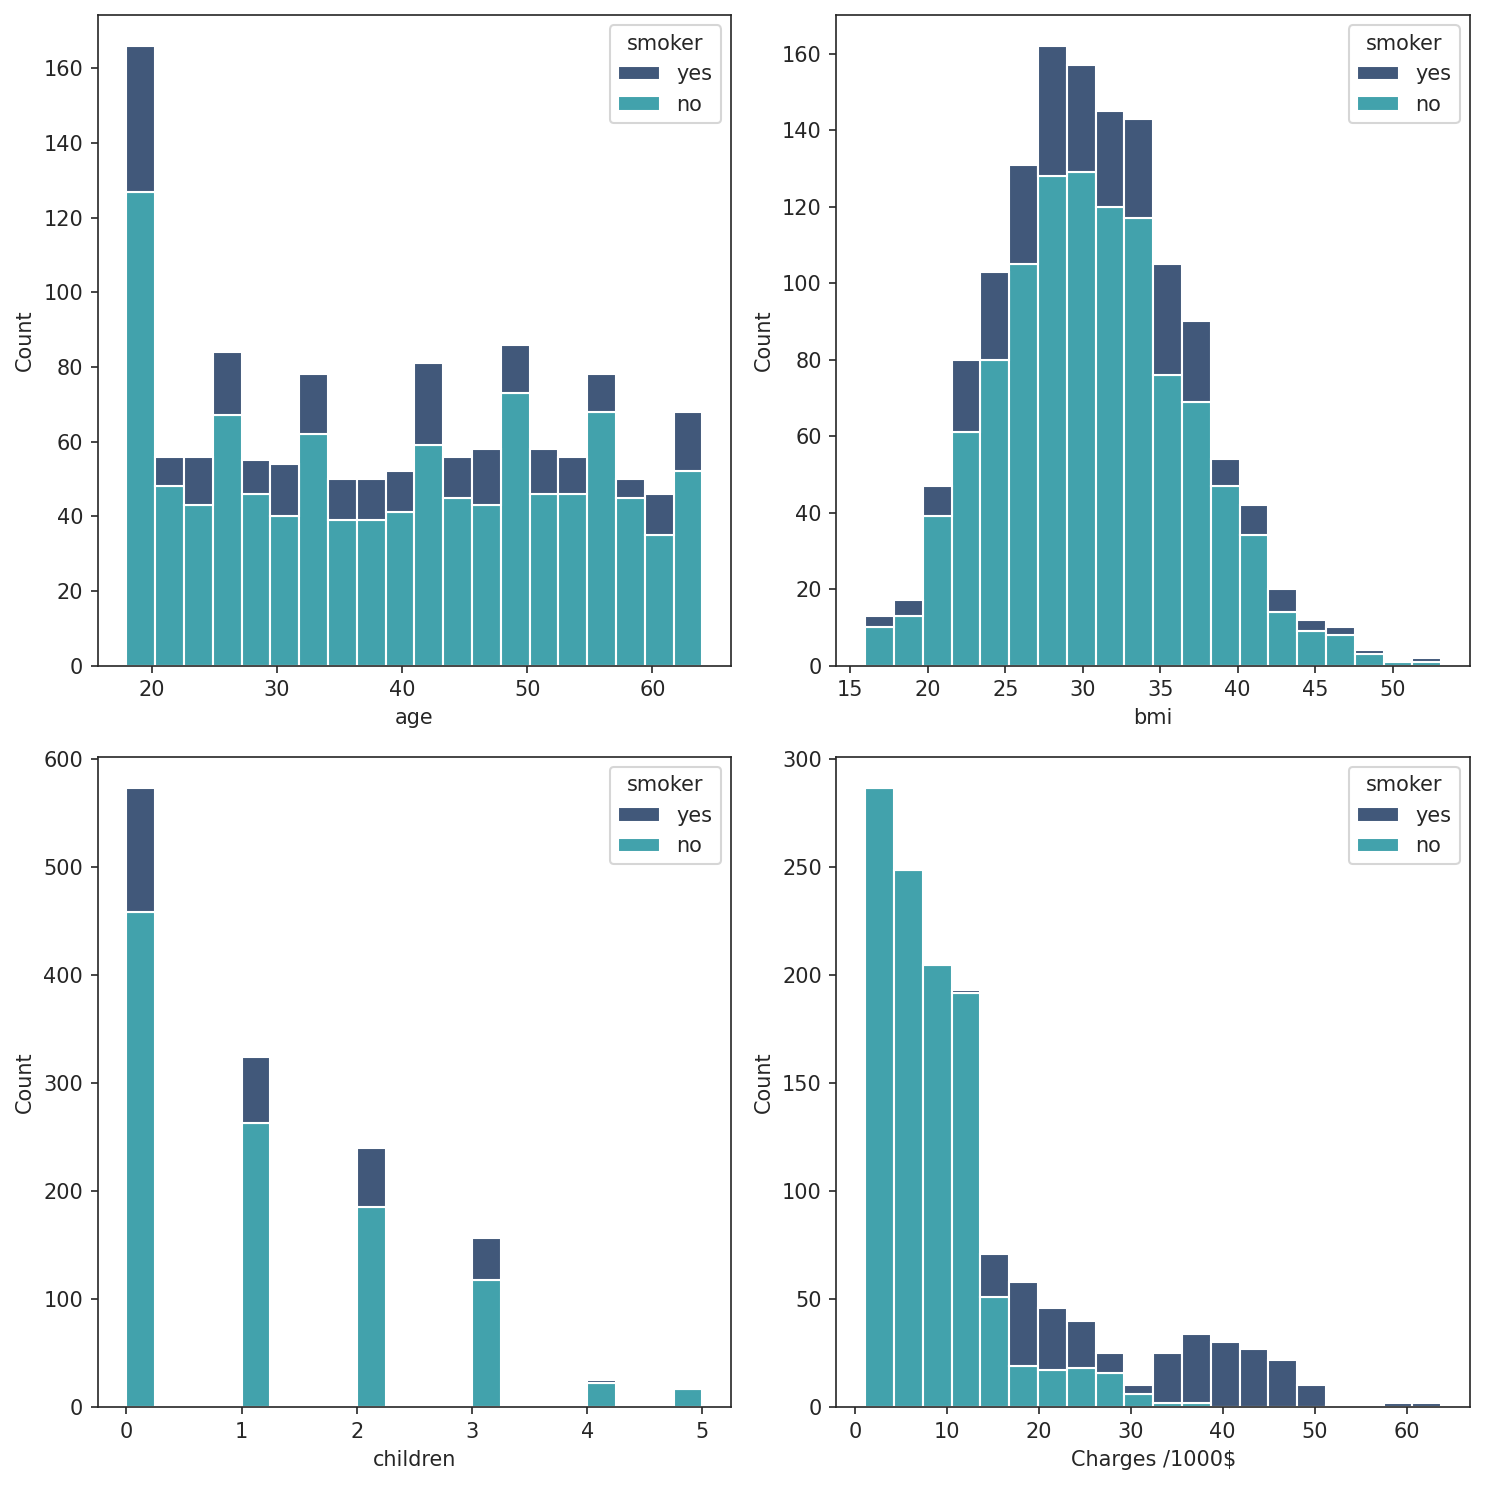

In [147]:
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(10,10), dpi=150, sharex=False, sharey=False)
sns.histplot(data=raw_df, x="age", hue="smoker", bins=20, multiple="stack", ax=axis.flat[0])
sns.histplot(data=raw_df, x="bmi", hue="smoker", bins=20, multiple="stack", ax=axis.flat[1])
sns.histplot(data=raw_df, x="children", hue="smoker", bins=20, multiple="stack", ax=axis.flat[2])
sns.histplot(data=raw_df, x="charges", hue="smoker", bins=20, multiple="stack", ax=axis.flat[3])
def my_formatter(x, pos):
    return f"{x / 1000:.0f}"
formatter = FuncFormatter(my_formatter)
axis.flat[3].xaxis.set_major_formatter(formatter)
axis.flat[3].set_xlabel("Charges /1000$")
plt.tight_layout()
plt.show()

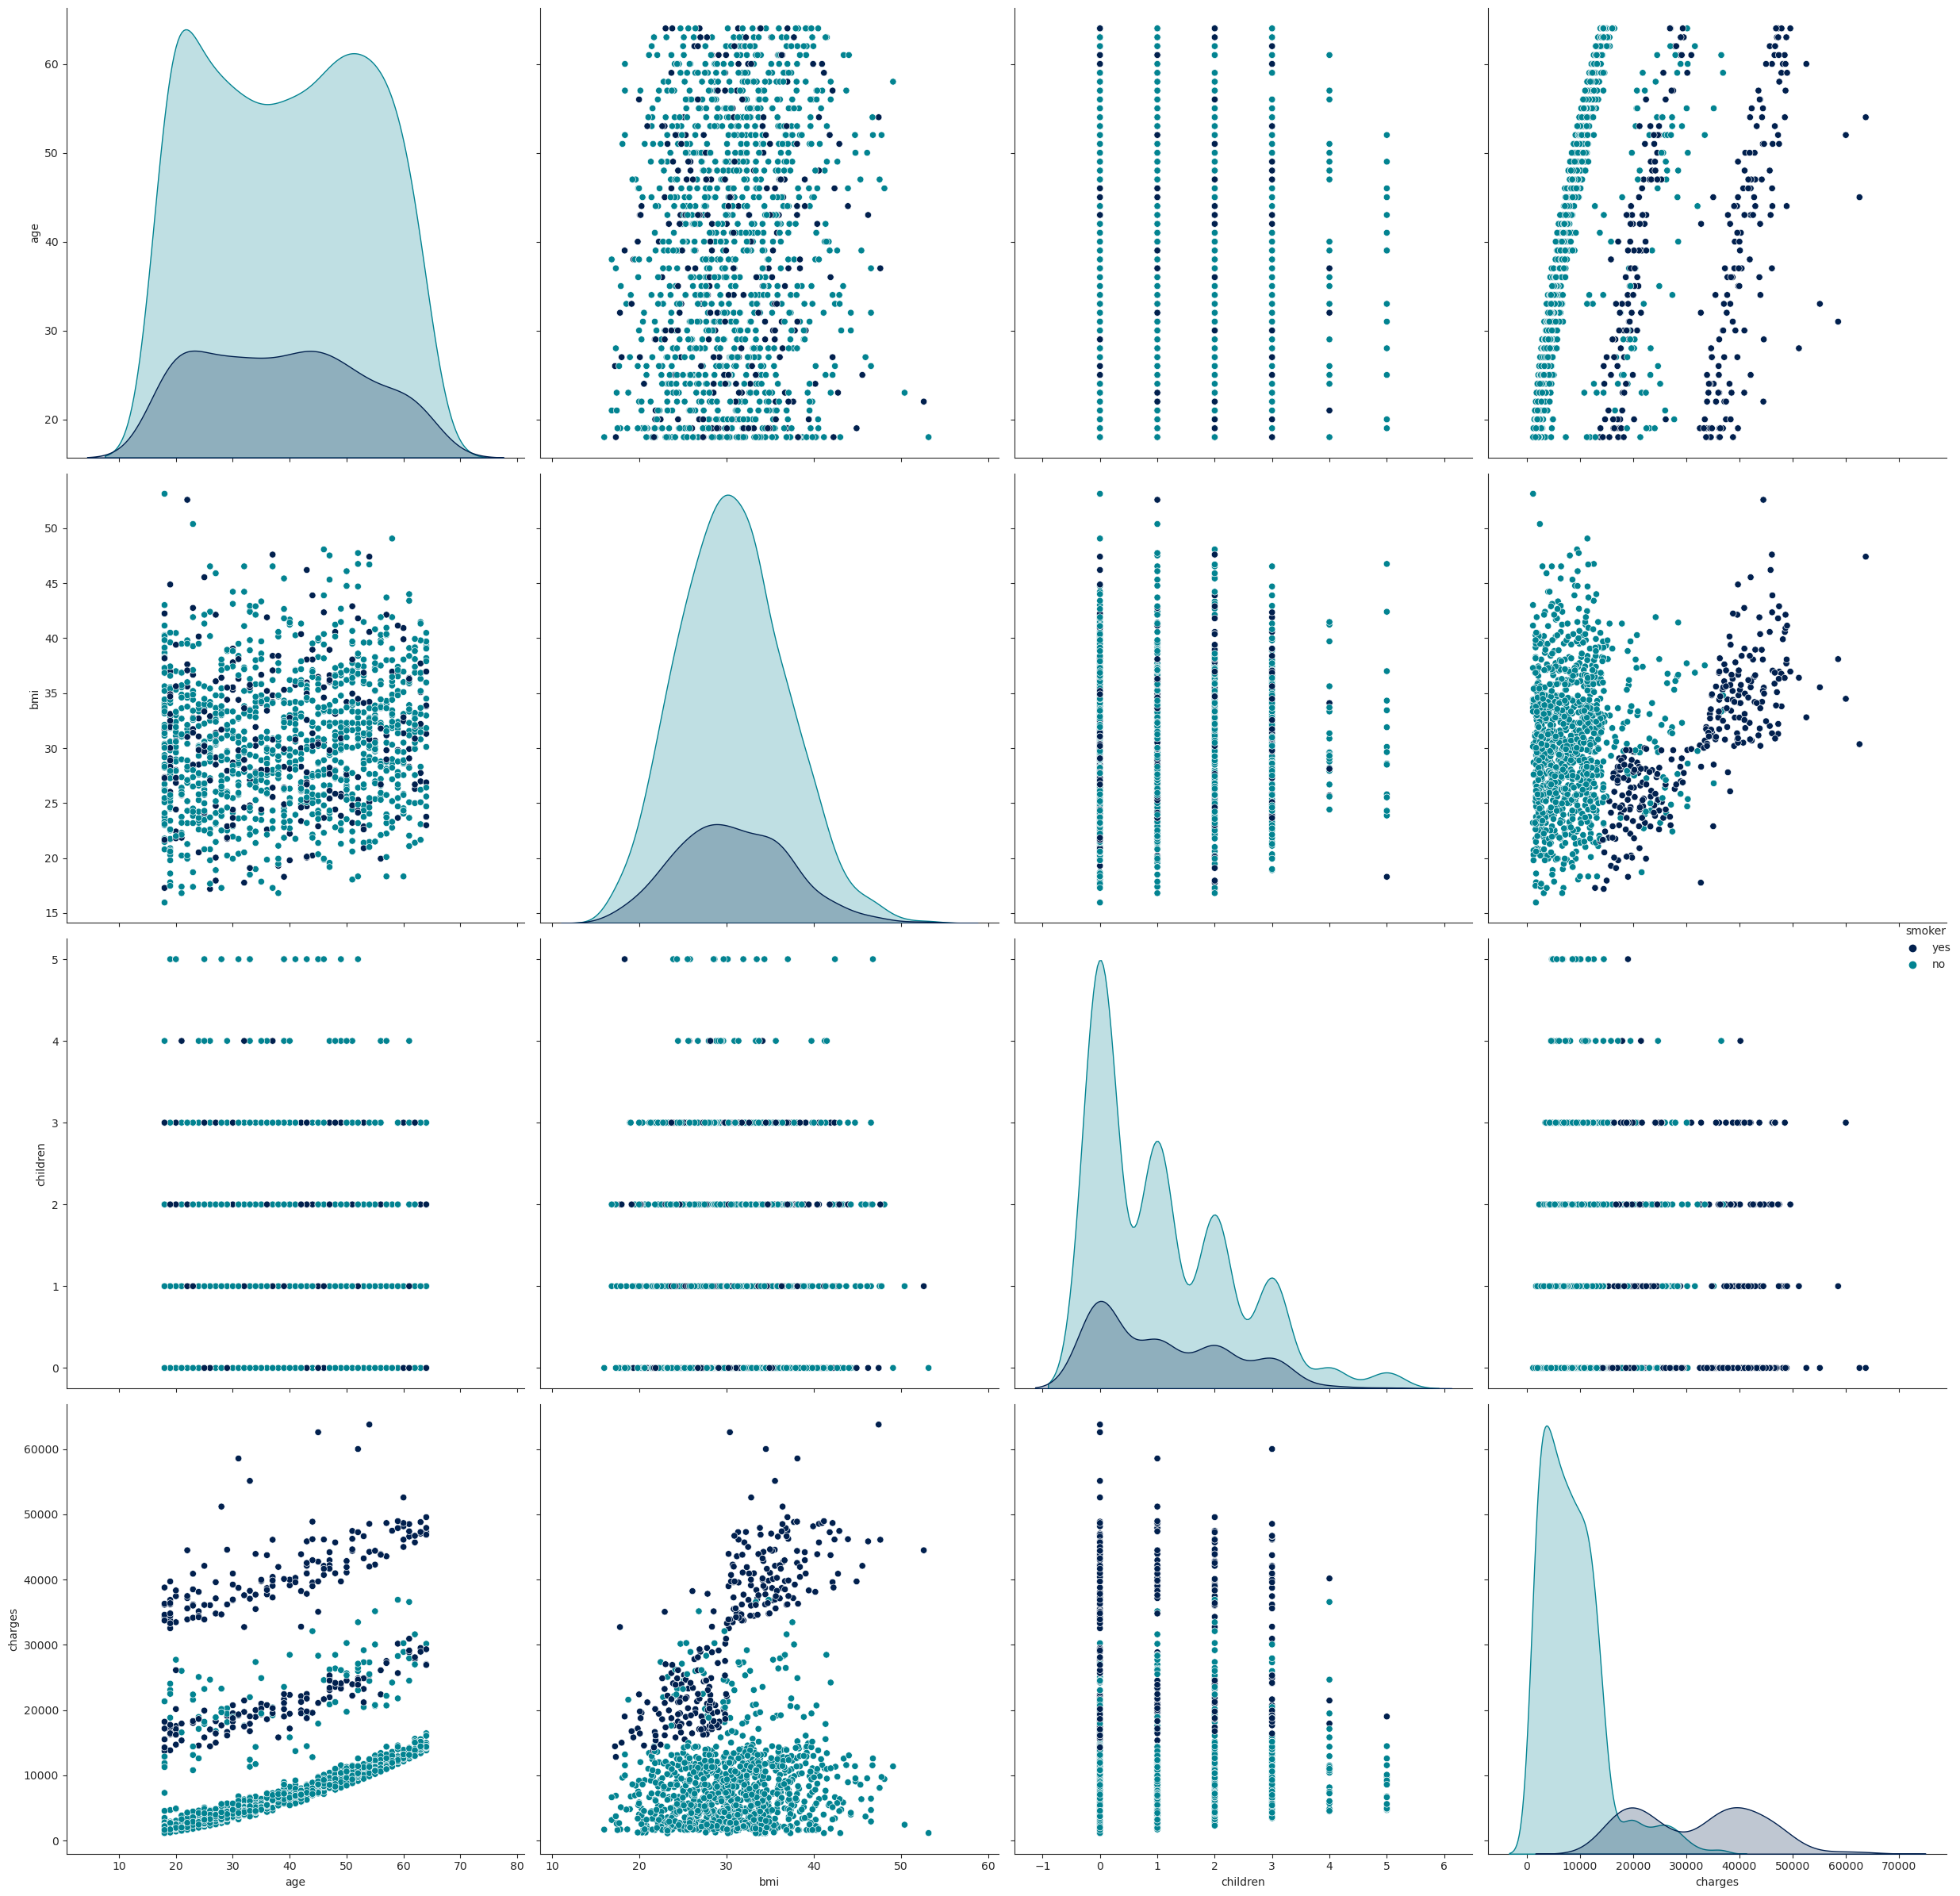

In [99]:
sns.pairplot(data=raw_df, height=6, hue="smoker")
plt.tight_layout();

## Training models

In [100]:
df = pd.get_dummies(raw_df, columns=["smoker", "sex", "region"], drop_first=True)
df.head()

,age,bmi,children,charges,smoker_yes,sex_male,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,0,1,0
2,28,33.000,3,4449.46200,0,1,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0


In [101]:
X_cols = list(set(df.columns) - set(['charges']))
Y_cols = ['charges']

In [102]:
X = df[X_cols].values
y = df[Y_cols].values

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [104]:
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

In [105]:
X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
Y_train = sc_y.transform(y_train)
Y_test = sc_y.transform(y_test)

In [106]:
model = LinearRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

In [107]:
y_pred.shape

(335, 1)

## Evaluating model

In [108]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print("r2: ", r2.round(4))

MSE: 295516136.22
r2:  -1.1636


In [109]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

In [110]:
model_ols = sm.OLS(y_train, X_train_sm)
results_ols = model_ols.fit()

In [111]:
print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     369.1
Date:                Mon, 03 Jun 2024   Prob (F-statistic):          1.99e-291
Time:                        16:28:10   Log-Likelihood:                -10172.
No. Observations:                1003   AIC:                         2.036e+04
Df Residuals:                     994   BIC:                         2.041e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.331e+04    194.835     68.336      0.0

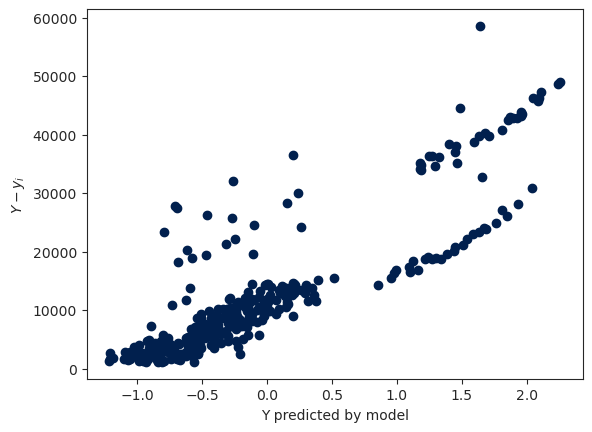

In [171]:
residuals = np.subtract(y_test, y_pred.reshape(-1, 1))
plt.scatter(y_pred, residuals)
plt.xlabel("Y predicted by model")
plt.ylabel(r"$Y-y_{i}$")
plt.show()

### Second model

These results can be optimized, through some useful and tricky transformations.

In [149]:
df_second = df.copy()
df_second["age2"] = df_second.age**2
df_second["overweight"] = (df_second.bmi >= 30).astype(int)
df_second["weight*smoker"] = df_second.overweight * df_second.smoker_yes
df_second.head()

,age,bmi,children,charges,smoker_yes,sex_male,region_northwest,region_southeast,region_southwest,age2,overweight,weight*smoker
0,19,27.900,0,16884.92400,1,0,0,0,1,361,0,0
1,18,33.770,1,1725.55230,0,1,0,1,0,324,1,0
2,28,33.000,3,4449.46200,0,1,0,1,0,784,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1089,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1024,0,0


In [165]:
def multl_model(df, col_y):
    """To train and test a multivariate linear model based on a set of x data in columns."""
    # Setting x_cols, which are the set of independent variables, and y_col which is the variable to predict.
    x_cols = list(set(df.columns) - set([col_y]))
    y_col = [col_y]
    
    X = df[x_cols].values
    y = df[y_col].values

    # Normalizing variables
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    sc_x = StandardScaler().fit(X) 
    sc_y = StandardScaler().fit(y)
    
    # Training the model
    X_train = sc_x.transform(X_train)
    X_test = sc_x.transform(X_test)
    y_train = sc_y.transform(y_train)
    y_test = sc_y.transform(y_test)
    
    # Testing the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return X_train, X_test, y_train, y_test, y_pred

In [166]:
X_sec_train, X_sec_test, y_sec_train, y_sec_test, y_sec_pred = multl_model(df=df_second, col_y="charges");

In [167]:
mse = mean_squared_error(y_sec_test, y_sec_pred)
r2 = r2_score(y_sec_test, y_sec_pred)
print(f"MSE: {mse:.2f}")
print("r2: ", r2.round(4))

MSE: 0.08
r2:  0.8953


In [175]:
X_sec_train_sm = sm.add_constant(X_sec_train)
X_sec_test_sm = sm.add_constant(X_sec_test)

model_sec_ols = sm.OLS(y_sec_train, X_sec_train_sm)
results_sec_ols = model_sec_ols.fit()

print(results_sec_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     544.3
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        17:24:19   Log-Likelihood:                -475.24
No. Observations:                1003   AIC:                             974.5
Df Residuals:                     991   BIC:                             1033.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0141      0.012      1.137      0.2

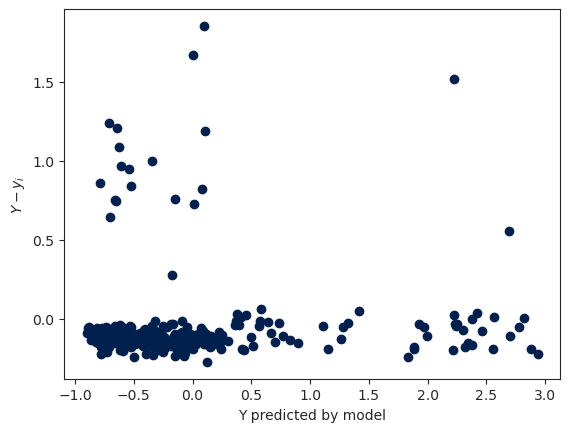

In [176]:
residuals_sec = np.subtract(y_sec_test, y_sec_pred.reshape(-1, 1))
plt.scatter(y_sec_pred, residuals_sec)
plt.xlabel("Y predicted by model")
plt.ylabel(r"$Y-y_{i}$")
plt.show()

Ignoring p values > 0.05:

In [246]:
p_values_sec_ols = (
    pd.DataFrame({
        "columns" : df_second.columns.to_list(),
        "p_values" : results_sec_ols.pvalues,
        "p>0.05" : results_sec_ols.pvalues > 0.05
    }
    )
)
# p_values_sec_ols
p_values_sec_ols[p_values_sec_ols["p>0.05"] == False]

,columns,p_values,p>0.05
4,smoker_yes,1.782052e-04,False
6,region_northwest,3.331953e-121,False
7,region_southeast,6.996769e-04,False
8,region_southwest,3.607761e-07,False
9,age2,3.860327e-03,False
10,overweight,2.901791e-109,False


In [247]:
x_pcols = ["smoker_yes", "region_northwest", "region_southeast", "region_southwest", "age2", "overweight", "weight*smoker"]
y_pcol = ["charges"]
    
X_third = df_second[x_pcols].values
y_third = df_second[y_pcol].values

# Normalizing variables
X_third_train, X_third_test, y_third_train, y_third_test = train_test_split(X_third,y_third)
sc_third_x = StandardScaler().fit(X_third) 
sc_third_y = StandardScaler().fit(y_third)
    
# Training the model
X_third_train = sc_third_x.transform(X_third_train)
X_third_test = sc_third_x.transform(X_third_test)
y_third_train = sc_third_y.transform(y_third_train)
y_third_test = sc_third_y.transform(y_third_test)
    
# Testing the model
model_third = LinearRegression()
model_third.fit(X_third_train, y_third_train)
y_third_pred = model_third.predict(X_third_test)

In [248]:
mse_third = mean_squared_error(y_third_test, y_third_pred)
r2_third = r2_score(y_third_test, y_third_pred)
print(f"MSE: {mse_third:.2f}")
print("r2: ", r2_third.round(4))

MSE: 0.16
r2:  0.8583


In [249]:
X_third_train_sm = sm.add_constant(X_third_train)
X_third_test_sm = sm.add_constant(X_third_test)

model_third_ols = sm.OLS(y_third_train, X_third_train_sm)
results_third_ols = model_third_ols.fit()

print(results_third_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     875.2
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        18:43:47   Log-Likelihood:                -408.45
No. Observations:                1003   AIC:                             832.9
Df Residuals:                     995   BIC:                             872.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0042      0.012     -0.363      0.7